# Building Histograms

### How to run this notebook:
* Give date and type of vehicle as arguments
* If simplified etapas file does not exist, then run RunDailyEtapasBuilder.runSimplifyEtapas(). If it already exists, then omit it
* If simplified perfiles file does not exist, then run RunDailyEtapasBuilder.runSimplifyPerfiles(). If it already exists, then omit it.

Run the builder in this order:
1. etapas_df = RunDailyEtapasBuilder.loadSimplifiedEtapas()
2. merged_df = RunDailyEtapasBuilder.includeTorniquetesDate(etapas_df)
3. clean_df = RunDailyEtapasBuilder.cleanDataFrame(merged_df)
4. sorted_df = RunDailyEtapasBuilder.sortDataFrame(clean_df)

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
import datetime

In [2]:
import RunDailyEtapasBuilder

Enter the date to analyze: 2017-07-19
Enter the vehicle to analyze: BUS
Consider ZP in perfiles file (0/1)?: 0


* Running the builder of the dataframe

In [3]:
#RunDailyEtapasBuilder.runSimplifyEtapas()
etapas_df = RunDailyEtapasBuilder.loadSimplifiedEtapas()
merged_df = RunDailyEtapasBuilder.mergeTurnstileData(etapas_df)
clean_df = RunDailyEtapasBuilder.cleanDataFrame(merged_df)
sorted_df = RunDailyEtapasBuilder.sortDataFrame(clean_df)
sorted_df = sorted_df.reset_index()

Not found in turnstile database: 1637796


* Counting.

In [4]:
print(etapas_df['id'].count())
print(merged_df['id'].count())
print(clean_df['id'].count())
print(sorted_df['id'].count())

2361310
2361310
2326044
2326044


* Adding necessary attributes

In [5]:
sorted_df['mismo_paradero'] = (sorted_df['par_subida']==sorted_df['par_subida'].shift()).fillna(False)
sorted_df['misma_patente'] = (sorted_df['sitio_subida']==sorted_df['sitio_subida'].shift()).fillna(False)
sorted_df['mismo_servicio'] = (sorted_df['servicio_subida']==sorted_df['servicio_subida'].shift()).fillna(False)

sorted_df.loc[(sorted_df.mismo_servicio == True) & (sorted_df.mismo_paradero == True) & (sorted_df.misma_patente == True), 'diferencia_tiempo'] = (sorted_df['t_subida']-sorted_df['t_subida'].shift())

sorted_df['diferencia_tiempo_secs'] = sorted_df['diferencia_tiempo'].dt.total_seconds()
sorted_df['si_torniquete'] = (sorted_df['fecha_instalacion']<=sorted_df['t_subida'])
sorted_df['si_2017_torniquete'] = ((sorted_df['fecha_instalacion']<=sorted_df['t_subida'])&(sorted_df['fecha_instalacion']>=pd.to_datetime('2017-01-01')))

* Filtering by mismo_paradero, misma_patente and by si_torniquete. This is a key part

In [6]:
filtered_df = sorted_df[(sorted_df.mismo_servicio==True) & (sorted_df.mismo_paradero==True) & (sorted_df.misma_patente==True)]
filtered_turnstile_df = filtered_df[filtered_df.si_2017_torniquete==True]
filtered_no_turnstile_df = filtered_df[filtered_df.si_torniquete==False]

* Counting and checking

In [7]:
print(filtered_df['id'].count())
print(filtered_turnstile_df['id'].count())
print(filtered_no_turnstile_df['id'].count())
checking = filtered_turnstile_df['id'].count() + filtered_no_turnstile_df['id'].count()
print(checking)

1427569
176655
998532
1175187


* Getting rid of unecessary dataframes

In [8]:
del etapas_df
del merged_df
del clean_df

TODO: Currently, there are rows with extremely high values for the 'diferencia_tiempo' attribute (e.g. >=25 mins). <strong>Be aware of this</strong>. <strike>This should be fixed considering the idExpedicion attribute present in the corresponding 'perfiles' database. The following graphs and descriptive statistics consider only the 95th percentile for the 'diferencia_tiempo_secs' attribute.</strike>

### Filtering by diferencia_tiempo<=97th percentile in the corresponding databases. <font color="red">BE AWARE.</font>

In [9]:
turnstile_97 = filtered_turnstile_df.diferencia_tiempo.quantile(0.97)
print ('Percentile 97th for 2017-turnstile database is: ' + str(turnstile_97))
no_turnstile_97 = filtered_no_turnstile_df.diferencia_tiempo.quantile(0.97)
print('Percentile 97th for without_turnstile database is: ' + str(no_turnstile_97))

Percentile 97th for 2017-turnstile database is: 0 days 00:00:26
Percentile 97th for without_turnstile database is: 0 days 00:00:26


In [10]:
turnstile_97_df = filtered_turnstile_df[filtered_turnstile_df.diferencia_tiempo<=turnstile_97]

In [11]:
no_turnstile_97_df = filtered_no_turnstile_df[filtered_no_turnstile_df.diferencia_tiempo<=no_turnstile_97]

In [12]:
turnstile_97_df.describe().round(3)

,index,id,nviaje,diferencia_tiempo,diferencia_tiempo_secs
count,171439.000,1.714390e+05,171439.000,171439,171439.000
mean,1164689.612,1.841129e+09,1.602,0 days 00:00:05.826748,5.827
std,688136.413,1.412185e+09,0.851,0 days 00:00:03.942299,3.942
min,0.000,1.091258e+06,1.000,0 days 00:00:00,0.000
25%,565922.500,4.243288e+08,1.000,0 days 00:00:04,4.000
50%,1165210.000,1.936278e+09,1.000,0 days 00:00:05,5.000
75%,1759257.000,3.169597e+09,2.000,0 days 00:00:07,7.000
max,2361291.000,4.293088e+09,13.000,0 days 00:00:26,26.000


In [13]:
no_turnstile_97_df.describe().round(3)

,index,id,nviaje,diferencia_tiempo,diferencia_tiempo_secs
count,969838.000,9.698380e+05,969838.000,969838,969838.000
mean,1185025.333,1.876182e+09,1.649,0 days 00:00:03.671872,3.672
std,679280.591,1.403204e+09,0.874,0 days 00:00:03.721403,3.721
min,1.000,1.091258e+06,1.000,0 days 00:00:00,0.000
25%,601351.250,4.270615e+08,1.000,0 days 00:00:02,2.000
50%,1185153.500,2.036011e+09,1.000,0 days 00:00:03,3.000
75%,1771435.750,3.170951e+09,2.000,0 days 00:00:04,4.000
max,2361308.000,4.293295e+09,22.000,0 days 00:00:26,26.000


* Plotting

In [14]:
turns_vals = turnstile_97_df.diferencia_tiempo_secs.values
no_turns_vals = no_turnstile_97_df.diferencia_tiempo_secs.values
max_97 = max(turnstile_97,no_turnstile_97).total_seconds()
bins = range(0,int(max_97),1)

In [15]:
colors = [(85,98,112),(78,205,196),(199,244,100),(255,107,107),(196,77,88)]
for i in range(len(colors)):
    r, g, b = colors[i]  
    colors[i] = (r / 255., g / 255., b / 255.)

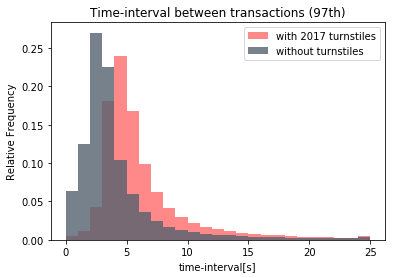

In [16]:
hist_fig, ax = plt.subplots()

plot1 = ax.hist(turns_vals,normed=True,bins=bins,color=colors[3], alpha=0.8, label='with 2017 turnstiles')
plot2 = ax.hist(no_turns_vals,normed=True,bins=bins,color=colors[0], alpha = 0.8, label='without turnstiles')


ax.set_title('Time-interval between transactions (97th)')
ax.set_xlabel('time-interval[s]')
ax.set_ylabel('Relative Frequency')
ax.legend()
plt.savefig('C:/Users/Tesista/Desktop/Evasion/03_report/02_Figs/2_daily2017-07-19.pdf')

In [17]:
import scipy as sp
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t.ppf((1+confidence)/2., n-1)
    return h, m-h, m, m+h

In [18]:
mean_confidence_interval(turnstile_97_df['diferencia_tiempo_secs'])

(0.018661473919037299,
 5.808087398857869,
 5.8267488727769061,
 5.8454103466959433)

In [19]:
mean_confidence_interval(no_turnstile_97_df['diferencia_tiempo_secs'])

(0.0074063770114209653,
 3.6644656263540898,
 3.6718720033655106,
 3.6792783803769313)

### Closed